In [29]:
# System libs
import os, csv, torch, numpy, scipy.io, PIL.Image, torchvision.transforms
# Our libs
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode
import numpy as np
import torch


In [30]:

# Set the device to CPU
device = torch.device("cpu")
colors = scipy.io.loadmat('color150.mat')['colors']
names = {}
with open('object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

def visualize_result(img, pred, index=None):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')
        
    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(numpy.uint8)

    # aggregate images and save
    im_vis = numpy.concatenate((img, pred_color), axis=1)
    display(PIL.Image.fromarray(im_vis))


In [31]:
# Network Builders
net_encoder = ModelBuilder.build_encoder(
    arch='resnet50dilated',
    fc_dim=2048,
    weights='ckpt\encoder_epoch_20.pth')
net_decoder = ModelBuilder.build_decoder(
    arch='ppm_deepsup',
    fc_dim=2048,
    num_class=150,
    weights='ckpt\decoder_epoch_20.pth',
    use_softmax=True)

crit = torch.nn.NLLLoss(ignore_index=-1)
segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)
segmentation_module.eval()

Loading weights for net_encoder


FileNotFoundError: [Errno 2] No such file or directory: 'ckpt\\encoder_epoch_20.pth'

In [ ]:
# Load and normalize one image as a singleton tensor batch
pil_to_tensor = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
        std=[0.229, 0.224, 0.225])  # across a large photo dataset.
])
pil_image = PIL.Image.open('Metric dataset\images\ADE_train_00000327.jpg').convert('RGB')
img_original = numpy.array(pil_image)
img_data = pil_to_tensor(pil_image)
singleton_batch = {'img_data': img_data[None]}
output_size = img_data.shape[1:]

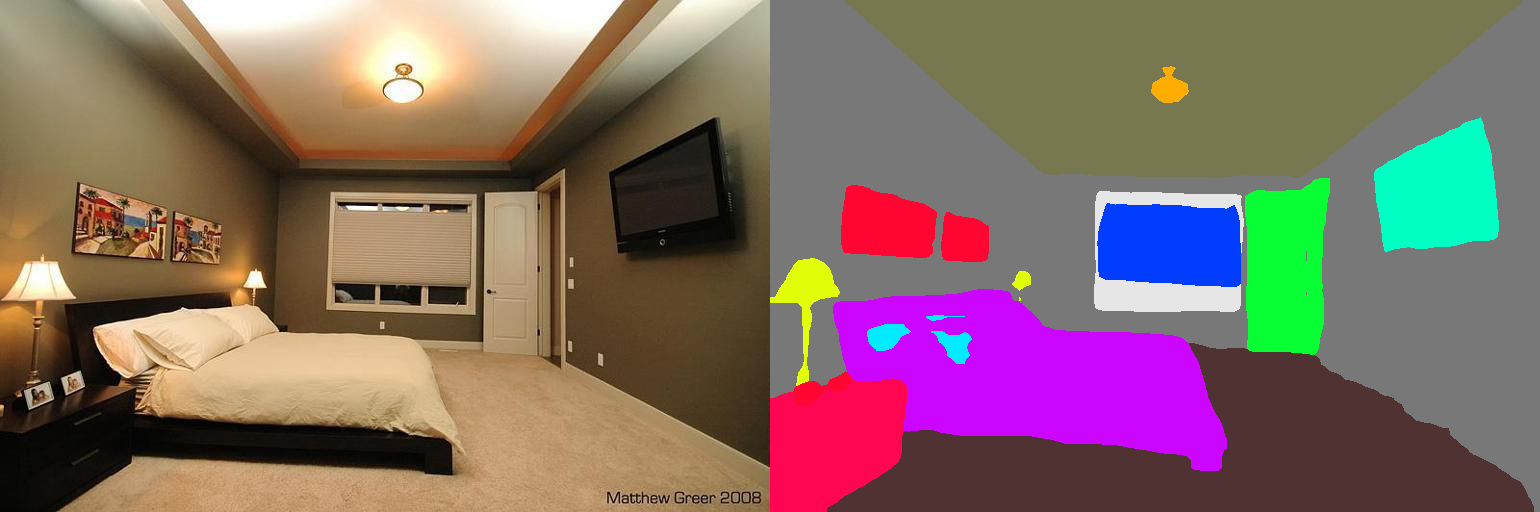

In [ ]:
# Run the segmentation at the highest resolution.
with torch.no_grad():
    scores = segmentation_module(singleton_batch, segSize=output_size)
    
# Get the predicted scores for each pixel
_, pred = torch.max(scores, dim=1)
pred = pred.cpu()[0].numpy()
visualize_result(img_original, pred)

In [ ]:
predicted_classes = numpy.bincount(pred.flatten()).argsort()[::-1]
class_names = [names[c+1] for c in predicted_classes[:8]]
class_names_str = " ".join(class_names)
class_names_str

'wall ceiling floor bed table door television blind'

In [32]:
class_names_str="wall ceiling floor bed table door television blind"
class_names_str

'wall ceiling floor bed table door television blind'

In [33]:
import os
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
Scene_Object_df = pd.read_csv('final_dataset 2 (1).csv')
Scene_Object_df.head(2)
pd.DataFrame(Scene_Object_df.Scene.unique())
Scene_Object_df['category_id'] = Scene_Object_df['Scene'].factorize()[0]
category_id_df = Scene_Object_df[['Scene', 'category_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Scene']].values)

# New dataframe
Scene_Object_df
     
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each object string into a vector
features = tfidf.fit_transform(Scene_Object_df.Objects).toarray()

labels = Scene_Object_df.category_id

print("Each of the %d strings of Objects is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))
N = 3
for Product, scene_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, Scene_Object_df['category_id']==scene_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(Product))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))
X = Scene_Object_df['Objects']
y = Scene_Object_df['Scene'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

Each of the 3794 strings of Objects is represented by 798 features (TF-IDF score of unigrams and bigrams)

==> bathroom:
  * Most Correlated Unigrams are: towel, bathtub, toilet
  * Most Correlated Bigrams are: mirror sink, bathtub sink, sink toilet

==> bedroom:
  * Most Correlated Unigrams are: sink, pillow, bed
  * Most Correlated Bigrams are: floor bed, ceiling bed, bed windowpane

==> dining_room:
  * Most Correlated Unigrams are: chair, buffet, chandelier
  * Most Correlated Bigrams are: table chair, flower chandelier, chandelier buffet

==> kitchen:
  * Most Correlated Unigrams are: microwave, refrigerator, stove
  * Most Correlated Bigrams are: sink stove, refrigerator stove, sink refrigerator

==> living_room:
  * Most Correlated Unigrams are: fireplace, coffee, sofa
  * Most Correlated Bigrams are: fireplace coffee, sofa rug, painting sofa


In [34]:

models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    XGBClassifier(n_estimators=100, max_depth=5, random_state=0)
]

# 10 Cross-validation
CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc


,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.963891,0.005694
LogisticRegression,0.966528,0.005953
MultinomialNB,0.953350,0.009776
RandomForestClassifier,0.890356,0.010750
XGBClassifier,0.959408,0.009244


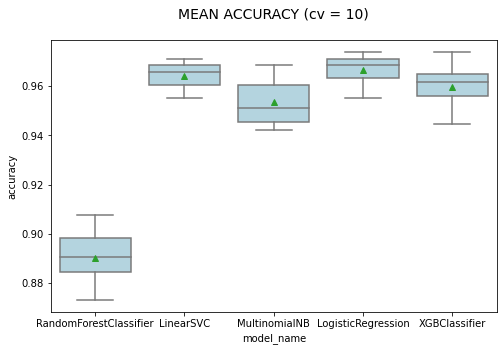

In [35]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 10)\n", size=14);

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')
fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)


In [37]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the encoder to your class labels and transform them
y_train_encoded = label_encoder.fit_transform(y_train)

# Now, you can fit the XGBClassifier with the encoded class labels
model = XGBClassifier(n_estimators=100, max_depth=5, random_state=0).fit(tfidf_vectorizer_vectors, y_train_encoded)


In [38]:
Objects=class_names_str
# Use the XGBClassifier to make predictions
predicted_label_index = model.predict(fitted_vectorizer.transform([Objects]))

# Use the label encoder to decode the index into the original class name
predicted_class_name = label_encoder.inverse_transform(predicted_label_index)
print(predicted_class_name)


['bedroom']


In [39]:
from sklearn.metrics import classification_report

# Transform the test set using the same TF-IDF vectorizer
tfidf_vectorizer_test = fitted_vectorizer.transform(X_test)

# Encode the test labels
y_test_encoded = label_encoder.transform(y_test)

# Make predictions on the test set
y_pred = model.predict(tfidf_vectorizer_test)

# Decode the predicted labels
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Print the classification report
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

    bathroom       0.99      0.97      0.98       177
     bedroom       0.98      0.99      0.99       337
 dining_room       0.93      0.95      0.94       106
     kitchen       0.95      0.95      0.95       147
 living_room       0.96      0.95      0.95       182

    accuracy                           0.97       949
   macro avg       0.96      0.96      0.96       949
weighted avg       0.97      0.97      0.97       949



In [40]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier  # Make sure to import XGBClassifier

# Create a list of models to ensemble
models = [
    ('logistic', LogisticRegression()),  # Your Logistic Regression model
    ('xgboost', XGBClassifier(n_estimators=100, max_depth=5, random_state=0))  # Your XGBoost model
]

# Create a VotingClassifier
ensemble = VotingClassifier(estimators=models, voting='hard')  # 'hard' for majority voting

# Fit the ensemble model
ensemble.fit(tfidf_vectorizer_vectors, y_train_encoded)

# Make predictions using the ensemble
ensemble_predictions = ensemble.predict(fitted_vectorizer.transform([Objects]))

# Decode the predicted label
ensemble_predicted_label = label_encoder.inverse_transform(ensemble_predictions)

# Evaluate the ensemble model on the test set
from sklearn.metrics import classification_report
tfidf_vectorizer_test = fitted_vectorizer.transform(X_test)
y_test_encoded = label_encoder.transform(y_test)
y_pred_ensemble = ensemble.predict(tfidf_vectorizer_test)
y_pred_ensemble_decoded = label_encoder.inverse_transform(y_pred_ensemble)

# Print the classification report
print(classification_report(y_test_encoded, y_pred_ensemble, target_names=label_encoder.classes_))


              precision    recall  f1-score   support

    bathroom       0.99      0.98      0.99       177
     bedroom       0.97      1.00      0.98       337
 dining_room       0.90      0.96      0.93       106
     kitchen       0.98      0.95      0.96       147
 living_room       0.99      0.93      0.96       182

    accuracy                           0.97       949
   macro avg       0.97      0.96      0.96       949
weighted avg       0.97      0.97      0.97       949



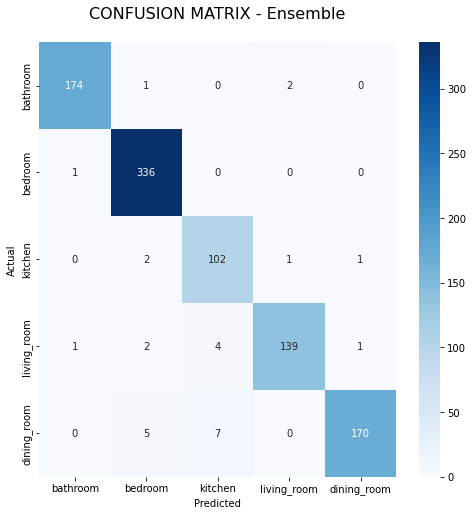

In [41]:
conf_mat = confusion_matrix(y_test_encoded, y_pred_ensemble)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Scene.values, 
            yticklabels=category_id_df.Scene.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Ensemble\n", size=16);

In [42]:
import pickle

# save the model
with open('XGB.pkl', 'wb') as file:
    pickle.dump(ensemble, file)
    
# load the model
with open('XGB.pkl', 'rb') as file:
    XGB = pickle.load(file)
